Import all the needed libraries

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

Loading the dataset and scaling it

In [4]:
# Load the MNIST dataset
(X_train, _), (X_test, _) = mnist.load_data()
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

The encoder model is makde from two hidden layers, both convolutional with a flatten layer followed by two dense layers which are in parallel branches

In [5]:
# Define the encoder model
latent_dim = 2
encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

The last layer (output layer) will be a custom one using smapling of the two values from the previous parallel layers

In [6]:
# Define the sampling layer
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

The decoder model tries to decode the encoded data. The shape of the model is similiar to the encoding model

In [7]:
# Define the decoder model
decoder_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(decoder_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

To create a VAE, the two models are combined

In [8]:
# Define the VAE model
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")
vae_outputs = decoder(encoder(encoder_inputs)[2])
vae = keras.Model(encoder_inputs, vae_outputs, name="vae")

A custo loss function is created

In [9]:
# Define the loss function
reconstruction_loss = keras.losses.binary_crossentropy(keras.backend.flatten(encoder_inputs), keras.backend.flatten(vae_outputs))
reconstruction_loss *= 28 * 28
kl_loss = 1 + z_log_var - keras.backend.square(z_mean) - keras.backend.exp(z_log_var)
kl_loss = keras.backend.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = keras.backend.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

The model is compiled and trained

In [10]:
# Compile the model
vae.compile(optimizer=keras.optimizers.Adam())

# Train the model
vae.fit(X_train, epochs=50, batch_size=128, validation_data=(X_test, None))

Epoch 1/50
469/469 [==============================] - 7s 13ms/step - loss: 208.5278 - val_loss: 173.6772
Epoch 2/50
469/469 [==============================] - 6s 12ms/step - loss: 169.7825 - val_loss: 166.9321
Epoch 3/50
469/469 [==============================] - 6s 12ms/step - loss: 165.5875 - val_loss: 164.0636
Epoch 4/50
469/469 [==============================] - 6s 12ms/step - loss: 163.3689 - val_loss: 162.0691
Epoch 5/50
469/469 [==============================] - 6s 12ms/step - loss: 161.6012 - val_loss: 160.1809
Epoch 6/50
469/469 [==============================] - 6s 12ms/step - loss: 160.3433 - val_loss: 159.5679
Epoch 7/50
469/469 [==============================] - 6s 12ms/step - loss: 159.3524 - val_loss: 158.7545
Epoch 8/50
469/469 [==============================] - 6s 12ms/step - loss: 158.4595 - val_loss: 157.7306
Epoch 9/50
469/469 [==============================] - 6s 12ms/step - loss: 157.6876 - val_loss: 157.2989
Epoch 10/50
469/469 [==============================] - 

The model is used to generate ten new samples. It can be seen, that these looks quite similar to the original dataset. This means, that generative model is working properly and can be used tp generate more data

1/1 [==============================] - 0s 58ms/step


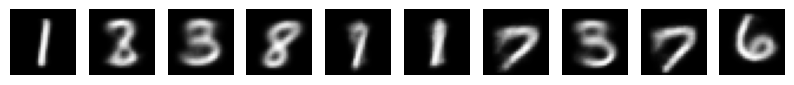

In [11]:
# Generate new samples
n_samples = 10
z = tf.random.normal(shape=(n_samples, latent_dim))
x_decoded = decoder.predict(z)

# Plot the samples
fig, axs = plt.subplots(1, n_samples, figsize=(n_samples, 1))
for i in range(n_samples):
    axs[i].imshow(x_decoded[i].reshape(28, 28), cmap='gray')
    axs[i].axis('off')
plt.show()